## Polished Code (Real-World Example)

### Coordinate Descent Algorithm with Elastic Net Regularization

#### Samir D Patel

This notebook is an overview of my own implementation of an an Elastic Net Regularized, Coordinate Descent Algorithm on a real-world dataset.

This was done as part of my DATA 558 Machine Learning course at the University of Washington.

#### NOTE:  To view the raw code for the functions run in this notebook, please refer to _'myelasticnet.py'_ in the _src_ folder.  
#### Or refer to https://github.com/samirpdx/PolishedCode_MachineLearning/blob/master/src/myelasticnet.py

In [1]:
%matplotlib inline  

# Only needed for IPython Notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing module I created containing code for implemented Elastic Net
import src.myelasticnet as enet


### EXAMPLE: "Hitters" data set (real world example)

##### The example we will go through uses a dataset from the real-world, "Hitters", from Introduction to Statistical Learning 

###### Loading the pre-processed dataset

In [2]:
X, Y = enet.load_data()

C:\Users\Samir\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Samir\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


###### Initialization of variables

In [3]:
n, p, beta_zero = enet.init_vars(X)

###### Creating list of lambda (regularization penalty) values to use for cross-validation.

In [4]:
lamb_list = [10**k for k in range(-7, 7)]

###### Running own implementation of cross-validation using K-Folds method and comparing to the cross-validation results of _ElasticNetCV_ from Sci-Kit Learn

In [5]:
cvdata, skopt, myoptlamb = enet.runcompareCV(lamb_list, 0.9, 3, X, Y)

In [6]:
print(' ')
print("Optimal Lambda (Regularization parameter) - Sci-Kit Learn's Elastic Net after Cross Validation")
print(' ')
print(skopt)
print(' ')
print('Optimal Lambda (Regularization parameter) - My Cyclic Coordinate Descent with Elastic Net after Cross Validation')
print(' ')
print(myoptlamb)

 
Optimal Lambda (Regularization parameter) - Sci-Kit Learn's Elastic Net after Cross Validation
 
0.01
 
Optimal Lambda (Regularization parameter) - My Cyclic Coordinate Descent with Elastic Net after Cross Validation
 
0.01


###### Printing results of cross-validation comparison

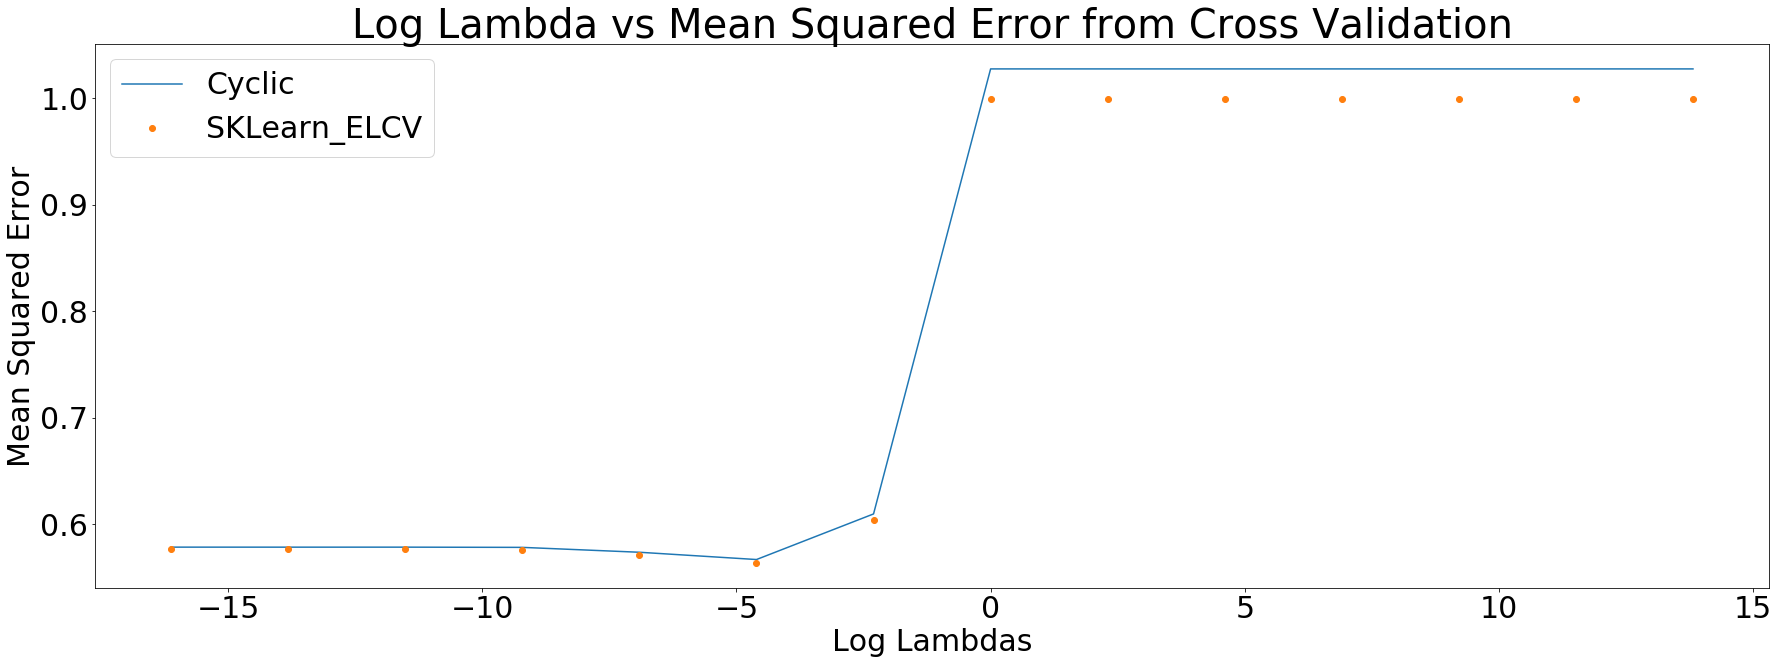

In [7]:
enet.cvplot(cvdata)

###### Calculation and comparison of objective values vs iteration count for both hand implemented cyclic and random coordinate descent algorithms.

In [8]:
beta_cyc_opt = enet.cycliccoorddescent(beta_zero, 0.9, myoptlamb, X, Y, max_iter = 10000)
print(' ')
print('Beta Coefficients - My Cyclic Coordinate Descent with Elastic Net using Optimal Lambda')
print(' ')
print(beta_cyc_opt[-1])


 
Beta Coefficients - My Cyclic Coordinate Descent with Elastic Net using Optimal Lambda
 
[-0.36894587  0.47367085  0.          0.          0.          0.19190076
 -0.0751211   0.          0.          0.06921317  0.38871061  0.28108198
 -0.21208831  0.1625586   0.03174123 -0.02114784  0.03338831 -0.13212537
  0.        ]


In [9]:
beta_rand_opt = enet.randcoorddescent(beta_zero, 0.9, myoptlamb, X, Y, max_iter = 10000)
print(' ')
print('Beta Coefficients - My Random Coordinate Descent with Elastic Net using Optimal Lambda')
print(' ')
print(beta_rand_opt[-1])


 
Beta Coefficients - My Random Coordinate Descent with Elastic Net using Optimal Lambda
 
[-0.36956179  0.47470901  0.          0.          0.          0.19146718
 -0.074562    0.          0.          0.07084659  0.38874283  0.27821695
 -0.21107883  0.16262678  0.03177575 -0.02110993  0.03348668 -0.13205805
  0.        ]


#### Plot of objective values across the iterations of the cyclic and random descent algorithms 

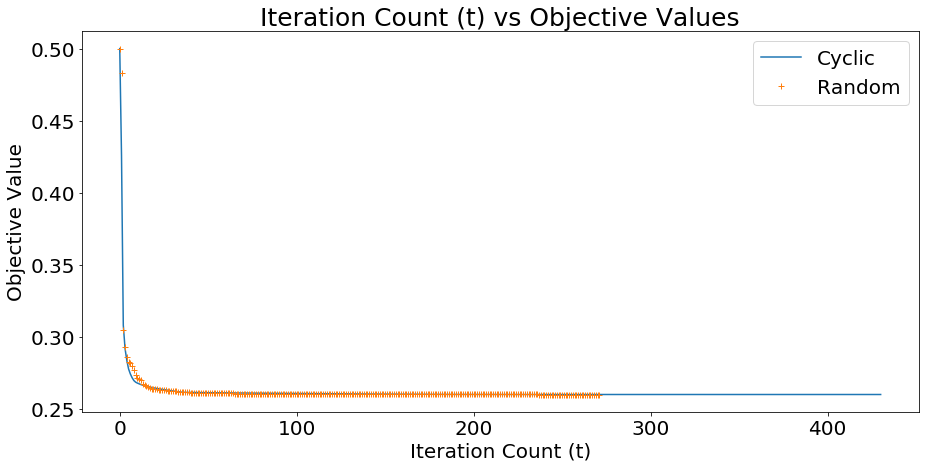

In [10]:
enet.objvalsplot(0.9, myoptlamb, X, Y, beta_cyc_opt, beta_rand_opt)

#### From the results above, we see that convergence happens relatively quickly for both the cyclic and random coordinate descent algorithms which also line up reasonably well in respect to one another.